In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import os

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
import os

data_dir = 'dataset'
batch_size = 8  
img_height = 224
img_width = 224

train_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'train'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'val'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

test_ds = tf.keras.utils.image_dataset_from_directory(
    os.path.join(data_dir, 'test'),
    image_size=(img_height, img_width),
    batch_size=batch_size
)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

model = models.Sequential([
    data_augmentation, 
    layers.Lambda(preprocess_input),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),


    
    layers.Dense(39, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

print("Starting Low-Memory Training...")
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[early_stopping]
)

model.save('plant_disease_model_augmented.h5')
print("Done! Model saved.")

Found 42863 files belonging to 39 classes.
Found 9192 files belonging to 39 classes.
Found 9219 files belonging to 39 classes.
Starting Low-Memory Training...
Epoch 1/50
5358/5358 [==============================] - 857s 155ms/step - loss: 0.7286 - accuracy: 0.7784 - val_loss: 0.2541 - val_accuracy: 0.9136
Epoch 2/50
5358/5358 [==============================] - 518s 97ms/step - loss: 0.4247 - accuracy: 0.8649 - val_loss: 0.2093 - val_accuracy: 0.9238
Epoch 3/50
5358/5358 [==============================] - 516s 96ms/step - loss: 0.3918 - accuracy: 0.8777 - val_loss: 0.1987 - val_accuracy: 0.9353
Epoch 4/50
5358/5358 [==============================] - 1214s 227ms/step - loss: 0.3611 - accuracy: 0.8888 - val_loss: 0.2446 - val_accuracy: 0.9223
Epoch 5/50
5358/5358 [==============================] - 513s 96ms/step - loss: 0.3432 - accuracy: 0.8948 - val_loss: 0.2120 - val_accuracy: 0.9328
Epoch 6/50
5358/5358 [==============================] - 515s 96ms/step - loss: 0.3390 - accuracy: 0.898

In [2]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 224, 224, 3)       0         
                                                                 
 lambda (Lambda)             (None, 224, 224, 3)       0         
                                                                 
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                      

In [ ]:
# import os

In [ ]:
base_model = ResNet50(
    include_top=False,
    weights='imagenet',
    input_shape=(img_height, img_width, 3)
)
base_model.trainable = False

model = models.Sequential([
    layers.Lambda(preprocess_input, input_shape=(img_height, img_width, 3)),
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(39, activation='softmax') 
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
base_model.trainable = True

for layer in base_model.layers[:100]:
    layer.trainable = False

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    initial_epoch=history.epoch[-1],
    callbacks=[early_stopping]
)

model.save('my_resnet_finetuned.h5')

print("Evaluating fine-tuned model...")
model.evaluate(test_ds)

NameError: name 'history' is not defined

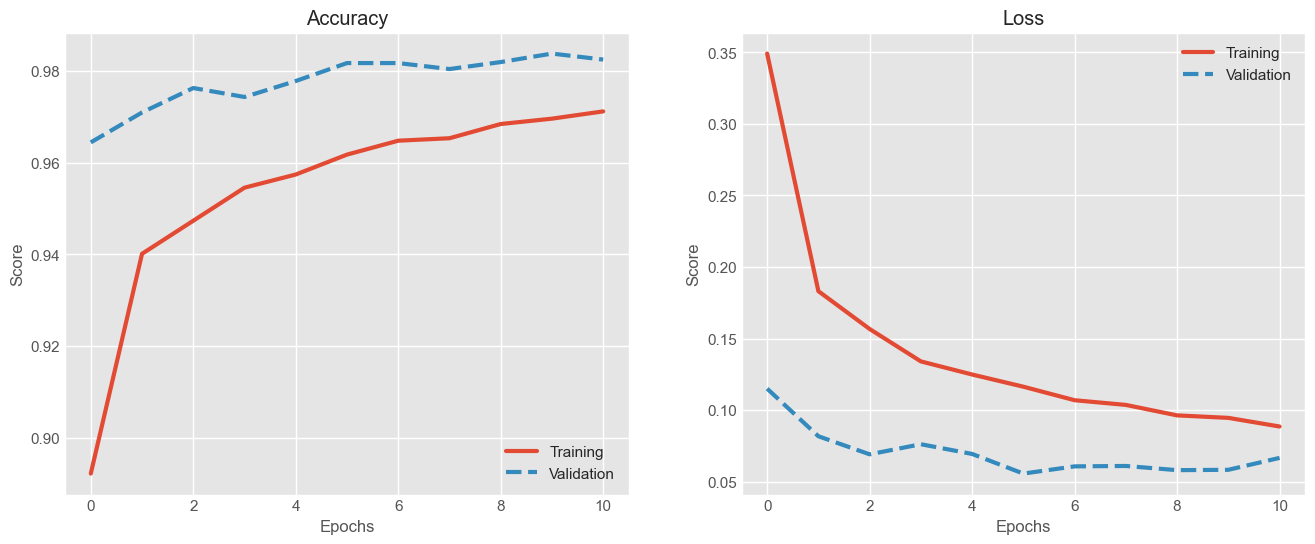

In [22]:
import matplotlib.pyplot as plt

plt.style.use('ggplot')

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(len(acc))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(epochs_range, acc, label='Training', linewidth=3)
ax1.plot(epochs_range, val_acc, label='Validation', linestyle='--', linewidth=3)
ax1.set_title('Accuracy')
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Score')
ax1.legend(loc='lower right')

ax2.plot(epochs_range, loss, label='Training', linewidth=3)
ax2.plot(epochs_range, val_loss, label='Validation', linestyle='--', linewidth=3)
ax2.set_title('Loss')
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Score')
ax2.legend(loc='upper right')

plt.show()

In [24]:
import numpy as np
from sklearn.metrics import classification_report

y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images, verbose=0)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

class_names = test_ds.class_names
print(classification_report(y_true, y_pred, target_names=class_names))

                                               precision    recall  f1-score   support

                           Apple___Apple_scab       0.99      0.99      0.99       151
                            Apple___Black_rot       0.97      1.00      0.99       147
                     Apple___Cedar_apple_rust       0.99      1.00      1.00       125
                              Apple___healthy       0.97      0.99      0.98       246
                    Background_without_leaves       0.99      0.99      0.99       172
                          Blueberry___healthy       1.00      1.00      1.00       226
                      Cherry___Powdery_mildew       0.98      0.97      0.98       158
                             Cherry___healthy       0.94      0.99      0.97       151
   Corn___Cercospora_leaf_spot Gray_leaf_spot       0.95      0.95      0.95       151
                           Corn___Common_rust       0.99      1.00      1.00       179
                  Corn___Northern_Leaf_Bli

In [33]:
# 1. Force Keras to use the correct accuracy calculator
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss='sparse_categorical_crossentropy',
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')]
)

# 2. Run the evaluation again
loss, accuracy = model.evaluate(test_ds)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

289/289 [==============================] - 57s 192ms/step - loss: 0.0253 - accuracy: 0.9933
Test Accuracy: 99.33%
